# Do the SSN radar range residuals imply lags in the DSN signal?

As first uncovered by a spreadsheet-based trajectory computation in [Ref](../README.md#references) [5] and subsequently validated to within the respective radar accuracies, the fit is readily obtained by assuming such shifts arising as lags in DSN tracking signal _concurrent with the radar tracking_.

Though the tracking from Goldstone did overlap the SSN measurements for at least a minute, most of the over 40 minutes of SSN tracking occurred _after_ loss of signal (LOS) at Goldstone. If the DSN signal is responsible, how can it possibly exhibit proportionality to the diminishing range after LOS? This problem is real, as demonstrated below with a naive simulation of the signal lags in the trajectory extrapolated from Goldstone.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value

In [2]:
sampling_interval = 60
sample_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
flyby_epochs = ssn_start + (sample_offsets << u.s)
print("Start and end epochs:", ssn_start, flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


### Simulate radar range data

The SSN radars use _coherent_ signal processing to detect the echoes over noise, but using matched filters and digital Fourier transform, and not a phase locked local oscillator in the reception process. Therefore only the DSN tracking would have had the lags. Relative to the DSN-inferred trajectory, represented by `near_goldsone_ephem` above, the radar data would have _negative_ lags. These _negative lags_ would be in _almost exact_ proportion to their respective ranges because the displacement of the DSN-inferred trajectory is very small compared to the ranges from ground, less than 1 km in ~35,000 km at the start and 0.5 km in ~15,000 km at the end of the SSN tracking period.

The radar range residuals are therefore estimated as _negative_ of the _lags_ in the DSN-inferred trajectory, hence as _positive_ displacements. The fact that their values come out negative means that the radars found NEAR _closer_ than expected on the DSN-inferred trajectory.

The residuals very closely resemble the [fit to within radar accuracies](https://earthshrink.github.io/flyby-analysis/near/fig_near_ssn.pdf) obtained [directly from Horizons topocentric range and range rate data](https://github.com/earthshrink/flyby-analysis).

In [5]:
altair_residuals = []
millstone_residuals = []

for e in flyby_epochs:
    rv = near_goldstone_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(rv, e)
    altair_residuals.append((ref_rr*ref_r/const.c).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(rv, e)
    millstone_residuals.append((ref_rr*ref_r/const.c).to_value(u.m))

In [6]:
print(altair_residuals)
print(millstone_residuals)

[-965.3395382572467, -952.3648933963681, -939.360861653721, -926.326557836631, -913.2610567644399, -900.163390995067, -887.0325483915544, -873.8674695152763, -860.6670448312913, -847.4301117099363, -834.155451207209, -820.8417846048279, -807.4877696890173, -794.0919967449764, -780.6529842417939, -767.1691741800201, -753.6389270714094, -740.0605165172935, -726.432123348732, -712.7518292878993, -699.0176100862016, -685.2273280901635, -671.3787241813833, -657.4694090315983, -643.4968536083269, -629.458378860462, -615.3511445067978, -601.1721368437159, -586.9181554812603, -572.5857989098131, -558.1714487927143, -543.6712528738009, -529.0811063836318, -514.3966318246327, -499.61315701480123, -484.7256912732768, -469.7288996411444, -454.61707505006524, -439.38410838371, -424.0234564278591, -408.52810778196726, -392.8905469181527]
[-891.5749906989873, -880.7889587951317, -869.9781888035163, -859.1418504119902, -848.2790785861956, -837.388971560092, -826.470588680408, -815.522948092327, -804.5

The plots of the residuals are exactly as shown in Figure 10 of [Ref](../README.md#references) [1] and validates the fit to range within the radar accuracies reported in [Ref](../README.md#references) [8].

The residual values are remarkably close to the values graphically found and recorded in [the LaTeX source](https://github.com/earthshrink/flyby-analysis/blob/refine_estimates/near/near_ssn.tex) of the [range fit graph](https://earthshrink.github.io/flyby-analysis/near/fig_near_ssn.pdf).

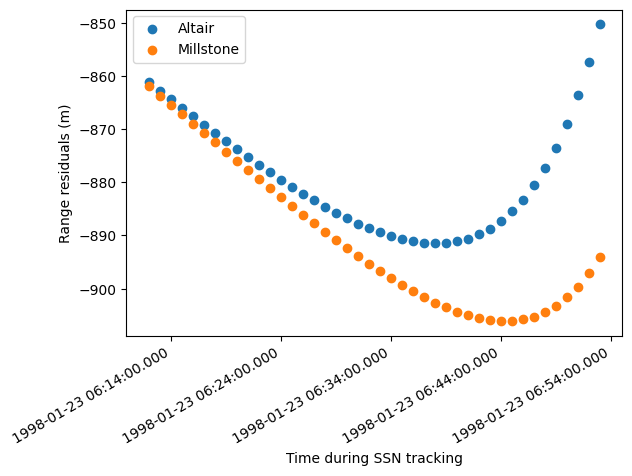

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy import visualization
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.scatter(flyby_epochs, altair_residuals, label="Altair")
    plt.scatter(flyby_epochs, millstone_residuals, label="Millstone")
    plt.legend(loc=0)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    ax.legend(loc="best")
    plt.gcf().autofmt_xdate()

## The problem

A simple change of trajectory from the inferred position and velocity lags at start does not lead to the same fit, however: 

In [8]:
ssn_start_r, ssn_start_rr, ssn_start_ra = dss25.range_rate_accel(near_ssn_start_rv, ssn_start)

lag = ssn_start_r/const.c
dr = lag*near_ssn_start_rv[1]
dv = lag*ssn_start_ra*near_ssn_start_rv[0]/ssn_start_r
#print(dr, dv)

delayed_r = near_ssn_start_rv[0] - dr
delayed_v = near_ssn_start_rv[1] - dv

delayed_orbit = Orbit.from_vectors(Earth, delayed_r, delayed_v, ssn_start)
describe_orbit(delayed_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133548324864586
Semilatus rectum: 19437.291873187096 km
Semimajor axix: -8494.370389285257 km
Periapse radius: 6908.937205055045 km , altitude: 530.8006050550448 km


In [9]:
delayed_ephem = delayed_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(delayed_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32465.168388047572 km 14334.038189479785 km
Start and end radial speeds: -7.678932858966106 km / s -6.935390759601991 km / s
Closest: 14334.038189479785 km speed 9.426738590126435 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.3022610163041843 deg


In [10]:
altair_residuals = []
millstone_residuals = []

for o in sample_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_goldstone_ephem.rv(e)
    delayed_rv = delayed_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    fixed_r, fixed_rr = ssrAltair.range_and_rate(delayed_rv, e)
    altair_residuals.append((ref_r - fixed_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    fixed_r, fixed_rr = ssrMillstone.range_and_rate(delayed_rv, e)
    millstone_residuals.append((ref_r - fixed_r).to_value(u.m))

The trajectory corresponding to lagging range at Goldstone LOS carries the lag through the SSN tracking period, remaining over 800 m from start to end. It would seem that the range proportionality seen in the SSN residuals could arise only from the radar signals themselves and not from the DSN's. 

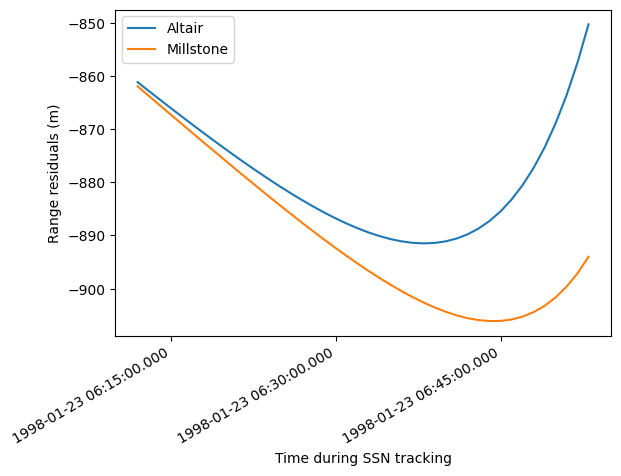

In [11]:
with visualization.time_support():
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.plot(flyby_epochs, altair_residuals, label="Altair")
    plt.plot(flyby_epochs, millstone_residuals, label="Millstone")
    plt.legend(loc=0)
    plt.gcf().autofmt_xdate()

In [12]:
from czml3.widget import CZMLWidget
from poliastro.czml.extract_czml import CZMLExtractor

czml = CZMLExtractor(flyby_epochs[0], flyby_epochs[-1], flyby_epochs.size)
#dss25.add_to_czml(czml, "#333")
#dss34.add_to_czml(czml, "#333")
ssrAltair.add_to_czml(czml, "#111")
ssrMillstone.add_to_czml(czml, "#111")
czml.add_orbit(near_goldstone_orbit)
czml.add_orbit(delayed_orbit)

CZMLWidget(czml.get_document())

CZMLWidget(document=Document(_values=[Preamble(id='document', version='1.0', name='document_packet', description=None, clock=IntervalValue(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>, _value=Clock(currentTime=datetime.datetime(1998, 1, 23, 6, 12, tzinfo=datetime.timezone.utc), multiplier=60, range=<ClockRanges.LOOP_STOP: 3>, step=<ClockSteps.SYSTEM_CLOCK_MULTIPLIER: 2>))), Packet(id='custom_properties', delete=None, name=None, parent=None, description=None, availability=None, properties={'custom_attractor': True, 'ellipsoid': [{'array': (6378136.6, 6378136.6, 6356751.9)}], 'map_url': ('https://upload.wikimedia.org/wikipedia/commons/c/c4/Earthmap1000x500compac.jpg',), 'scene3D': True}, position=None, orientation=None, viewFrom=None, billboard=None, box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=None, model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS0', delete=None, name=None, parent=None, description='Altair', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[-6143471.429543289, 1364300.4818256705, 1034339.9636133286], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<LabelStyles.FILL: 1>, scale=None, showBackground=None, backgroundColor=None, fillColor=Color(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, rgba='#111', rgbaf=None), outlineColor=None, outlineWidth=1.0, pixelOffset=None), model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS1', delete=None, name=None, parent=None, description='Millstone', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[1492298.8700490487, -4457675.543085808, 4296323.883602885], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<Labe

See [screenshot](near_sim_ssn_residuals.png)